In [1]:
from numba import njit
from numba_kdtree import KDTree
import numpy as np
import arepo
import matplotlib.pyplot as plt
import h5py as h5
from scipy import signal

from tqdm import tqdm_notebook as tqdm

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [36]:
bprop_path = '/n/home01/abeane/starbar/plots/bar_prop/data/'

def read_bar_angle(name, lvl):
    t = h5.File(bprop_path + 'bar_prop_' + name + '-' + lvl + '.hdf5', mode='r')
    out = t['bar_angle'][:]
    tlist = t['tlist'][:]
    print(t.keys())
    t.close()
    
    fixed = fix_bar_angle(out)
    ps = np.gradient(fixed, tlist)

    return out, ps

In [4]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos


In [5]:
idx = 300
sn = read_snap(idx, 1, lvl='lvl3', parttype=None, fields=None)

bangle, ps = read_bar_angle(sim_list[1], 'lvl3')
bangle = bangle[idx]
ps = ps[idx]

<KeysViewHDF5 ['bar_angle', 'bar_prop', 'idx_list', 'tlist']>


In [6]:
center = np.array([200., 200., 200.])

pos = []
pos.append(sn.part0.pos.value)
pos.append(sn.part1.pos.value)
pos.append(sn.part2.pos.value)
pos.append(sn.part3.pos.value)
pos.append(sn.part4.pos.value)
pos = np.concatenate(pos)

pos = pos - center
pos = rotate_pos(pos, -bangle)

acc = []
acc.append(sn.part0.acce)
acc.append(sn.part1.acce)
acc.append(sn.part2.acce)
acc.append(sn.part3.acce)
acc.append(sn.part4.acce)
acc = np.concatenate(acc)

acc = rotate_pos(acc, -bangle)

pos_halo = sn.part1.pos.value
pos_halo = pos_halo - center
pos_halo = rotate_pos(pos_halo, -bangle)

vel_halo = sn.part1.vel.value
vel_halo = rotate_pos(vel_halo, -bangle)

pot_halo = sn.part1.pot.value

# also subtract uniform rotation
omega = np.array([0., 0., ps])
vel_halo = vel_halo - np.cross(omega, pos_halo)

vel_halo_inert = sn.part1.vel.value
vel_halo_inert = rotate_pos(vel_halo_inert, -bangle)

# frame_rot_x = pos_halo[:,1] * ps
# frame_rot_y = - pos_halo[:,0] * ps
# vel_halo[:,0] -= frame_rot_x
# vel_halo[:,1] -= frame_rot_y

In [7]:
tree = KDTree(pos)

In [8]:
@njit
def grav(pos, vel, acc, tree, omega=np.array([0., 0., 0.])):
    _, key = tree.query(pos)
    
#     out = np.zeros(pos.shape)
    
#     for i in range(len(out)):
#         out[i] = acc[key[i]]

    out = acc[key[0]]
    
    coriolis = -2. * np.cross(omega, vel)
    centrifugal = - np.cross(omega, np.cross(omega, pos))
    
    
    return out + coriolis + centrifugal

In [9]:
@njit
def integrate_orbit(dt, tmax, pos0, vel0, tree, acc_tree, ps=0.0):
  
    continue_integrating = True
    
    omega = np.array([0., 0., ps])


    posi = pos0
    veli = vel0
    
    t = 0.0

    pos = np.zeros((int(tmax/dt)+1, 3)).astype(np.float64)
    vel = np.zeros((int(tmax/dt)+1, 3)).astype(np.float64)
    tlist = np.zeros(int(tmax/dt)+1).astype(np.float64)

    for j in range(3):
        pos[0][j] = pos0[j]
        vel[0][j] = vel0[j]
    
    i = 0

    while continue_integrating:
#         print(dt)
        t = t + dt
    
        k1 = grav(posi, veli, acc_tree, tree, omega)[0]
        vel1 = veli + k1 * dt/2.0
        pos1 = posi + (dt/2.0)*((veli+vel1)/2.0)
        
        k2 = grav(pos1, vel1, acc_tree, tree, omega)[0]
        vel2 = veli + k2*dt/2.0
        pos2 = posi + (dt/2.0)*((veli+vel2)/2.0)
        
        k3 = grav(pos2, vel2, acc_tree, tree, omega)[0]
        vel3 = veli + k3*dt
        pos3 = posi + dt * ((veli+vel3)/2.0)
        
        k4 = grav(pos3, vel3, acc_tree, tree, omega)[0]
        
        velip1 = veli + (dt/6.0) * (k1 + 2.*k2 + 2.*k3 + k4)
        posip1 = posi + (dt/6.0) * (veli + 2.*vel1 + 2.*vel2 + vel3)
    
    
#         posip1 = posi + veli*dt + 0.5*acci * dt*dt
        
#         accip1 = grav(posip1, acc_tree, tree)[0]
        
#         velip1 = veli + 0.5 * (acci + accip1) * dt

        # now determine if we need to continue integrating
        if t > tmax:
            continue_integrating = False

        # update i
        i = i+1
        for j in range(3):
            pos[i][j] = posip1[j]
            vel[i][j] = velip1[j]
            tlist[i]=t
        
        posi = np.copy(posip1)
        veli = np.copy(velip1)
#         acci = np.copy(accip1)

    # convert back to inertial reference frame
    ang = ps * tlist
    pos_inertial = np.copy(pos)
    pos_inertial[:,0] = pos[:,0] * np.cos(ang) - pos[:,1] * np.sin(ang)
    pos_inertial[:,1] = pos[:,0] * np.sin(ang) + pos[:,1] * np.cos(ang)
    
    vel_inertial = np.copy(vel)
    vel_inertial[:,0] = vel[:,0] * np.cos(ang) - vel[:,1] * np.sin(ang)
    vel_inertial[:,1] = vel[:,0] * np.sin(ang) + vel[:,1] * np.cos(ang)
    vel_inertial = vel_inertial + np.cross(pos_inertial, omega)
        
    return pos_inertial, vel_inertial, tlist

In [39]:
@njit
def fix_bar_angle(bar_angle):
    out = np.zeros(len(bar_angle))
    out[0] = bar_angle[0]

    for i in range(1, len(bar_angle)):
        dphi = bar_angle[i] - bar_angle[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        if dphi > np.pi:
            dphi -= 2. * np.pi
        
        out[i] = out[i-1] + dphi
    
    return out

@njit
def compute_phi_freq(pos0, vel0, tree, acc, ps):
    dt = 0.002
    tmax = 20.0
    x, v, t = integrate_orbit(dt, tmax, pos0, vel0, tree, acc, ps)
    phi = np.arctan2(x[:,1], x[:,0])
    R = np.zeros(len(x))
    for i in range(len(x)):
        R[i] = np.sqrt(x[i][0]*x[i][0] + x[i][1]*x[i][1])
    
#     R = np.linalg.norm(x[:,:2], axis=1)
    
#     phi_ft = np.fft.rfft(phi)
#     R_ft = np.fft.rfft(R)
#     freq = np.fft.rfftfreq(len(t), t[1]-t[0])
    
    phi_fixed = fix_bar_angle(phi)
    
    Omega_phi = (phi_fixed[-1]-phi_fixed[0])/tmax
    
    fs = 1./(t[1]-t[0])
#     freq, PR = signal.periodogram(R, fs)
#     Omega_R = 2.*np.pi * freq[np.argmax(PR)]
    
    
    
    return Omega_phi, Omega_R

In [40]:
%%time
compute_phi_freq(pos_Ecut[0], vel_Ecut[0], tree, acc, ps)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'periodogram' of type Module(<module 'scipy.signal' from '/n/home01/abeane/.local/lib/python3.6/site-packages/scipy/signal/__init__.py'>)
[1m
File "<ipython-input-39-a16adced223f>", line 38:[0m
[1mdef compute_phi_freq(pos0, vel0, tree, acc, ps):
    <source elided>
    fs = 1./(t[1]-t[0])
[1m    freq, PR = signal.periodogram(R, fs)
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at <ipython-input-39-a16adced223f> (38)[0m
[1m
File "<ipython-input-39-a16adced223f>", line 38:[0m
[1mdef compute_phi_freq(pos0, vel0, tree, acc, ps):
    <source elided>
    fs = 1./(t[1]-t[0])
[1m    freq, PR = signal.periodogram(R, fs)
[0m    [1m^[0m[0m


127199


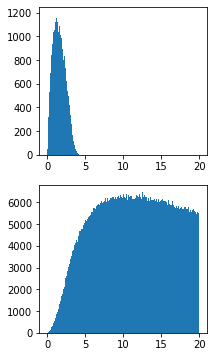

In [20]:
E = 0.5 * (np.linalg.norm(vel_halo_inert, axis=1))**2. + pot_halo
# plt.hist(E/1E6, bins=np.linspace(-0.3, 0.1, 1000))

R = np.linalg.norm(pos_halo, axis=1)
fig, ax = plt.subplots(2, 1, figsize=(3, 6))

Ecut = -0.2 * 1E6

print(len(np.where(E<Ecut)[0]))

ax[0].hist(R[E<Ecut], bins=np.linspace(0, 20, 1000))
ax[1].hist(R[E>=Ecut], bins=np.linspace(0, 20, 1000))

plt.show()


In [21]:
Ecut = -0.2 * 1E6

pos_Ecut = pos_halo[E < Ecut]
vel_Ecut = vel_halo[E < Ecut]

In [31]:
from joblib import Parallel, delayed
freq_list = Parallel(n_jobs=32, backend='threading') (delayed(compute_phi_freq)(pos_Ecut[i], vel_Ecut[i], tree, acc, ps) for i in tqdm(range(10000)))
freq_list = np.array(freq_list)

A Jupyter Widget

KeyboardInterrupt: 

In [28]:
plt.hist(ans[:,0], bins=200)
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [30]:
np.array(ans)

array([[-24.0626415 ,   0.31412785],
       [  5.92826558,   0.31412785],
       [ -6.06410241,   0.31412785],
       [ 35.45061706,   0.31412785],
       [ -1.67058047,   2.82715067],
       [  1.03458664,   0.31412785],
       [ -0.86652714,   0.31412785],
       [ 34.12021437,   0.31412785],
       [ -3.69152638,   0.31412785],
       [ -2.94021344,   0.62825571],
       [ -0.25530757,   0.62825571],
       [ 26.98517919,  40.52249298],
       [ 19.57113974,   0.62825571],
       [ 26.11586904,   0.31412785],
       [ -2.14563197,   0.31412785],
       [ -3.18897225,   0.31412785],
       [ -5.30593106,   0.31412785],
       [-33.15435054,   0.31412785],
       [ 11.36054496,   0.31412785],
       [  3.48976804,  40.83662083],
       [-11.88619857,   0.31412785],
       [-37.39743767,   0.31412785],
       [  1.22427081,   0.31412785],
       [ -3.53599809,   0.31412785],
       [ 24.74851861,   0.31412785],
       [ -9.27305382,   8.16732417],
       [  6.24409709,   2.82715067],
 